# Fake news Classification with Logistic Regression

With the maturity of the internet, fake news has become much more common in recent years. Fake news is disinformation which is disguised as "real" news to influence public opinion. Can we use machine learning to classify news articles fake or real? Text contains a lot of information let's investigate if we can use it! 

In this blog post, we construct a simple logistic regression model to classify news articles to be fake or real. We'll be using bag-of-words and tf-idf representations to vectorize our textual data.

I try to recreate and improve the Bayesian model from  George McIntire detailed in [this](https://opendatascience.com/how-to-build-a-fake-news-classification-model/) post with a logistic regression model.

## 1. Load Data

Let's load news data and look at the first few rows. We'll be using only the core text of the articles to train our classifier. This will keep our model simple. You could also use the title or the title in combination with the full text or other extracted features.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

news = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv").iloc[:, 1:]
news = news[["text", "label"]]
news.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


The data can be downloaded [here](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv) and is provided by DataCamp. 

In the cell above I display the text column which contains the text of the article and the label columns. This las one holds information on whether or not the text is fake.

## 2. Exploratory Data Analysis

Before modeling the data, let's first take a look at the textual data! I would like to see if there is a simple difference between real and fake texts. There are several basic ways to look at our textual data. We could look at the number of words of our texts, the number of characters or the average length of words. Furthermore, it maybe could be useful to do part of speech (POS) tagging, do entity recognition or compute readability scores and identify differences between the text classes.

Let's start by printing the first sentence of a fake and real news article to see if these text parts give us clues about fake or realness. We do this by using a string method to split on a new line. 

In [2]:
print("FAKE ARTICLE: {} \n".format(news["text"].str.split('\n')[0][0]))
print("REAL ARTICLE: {}".format(news["text"].str.split('\n')[2][0]))

FAKE ARTICLE: Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam.  

REAL ARTICLE: U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.


I couldn't really classify these articles to be real or fake, at least not based on their first sentences. Before diving deeper into the exploratory data analysis, let's look at the distribution of our target labels.

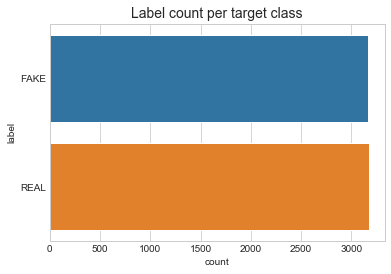

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

sns.set_style('whitegrid')

sns.countplot(y ="label", data=news)
plt.title("Label count per target class", fontsize=14);

The figure above shows an even distribution of labels. There are as many fake as real news articles in our datasets. We set our baseline at around 50%. Anything above this score will be better than random guessing.

### 2.1 Number of words
Let's see if there's a difference between the number of words used in real articles compared to fake news texts. We first look at some simple summary statistics to get a feel for the data. We apply a lambda function that splits every word in the texts, stores it in a list and gets the length of the list. After that, we store word count back into a new column in our original data frame.

In [4]:
news["word_count"] = news['text'].apply(lambda x: len(x.split()))
news.head()

,text,label,word_count
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,1296
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,446
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,431
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,404
4,It's primary day in New York and front-runners...,REAL,317


We can now compute several summary statistics on the word count grouped by there label. Let's see if there are differences in word count between fake and real articles.

In [5]:
news.groupby('label')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
FAKE,3164.0,679.129267,958.962790,0.0,212.0,421.0,830.0,20891.0
REAL,3171.0,873.257647,722.483569,7.0,450.5,771.0,1123.0,7602.0


The output above suggests that real news articles have a greater average and median word count, with less variation (standard deviation and percentiles) than the fake news articles. The range of word count of fake news articles is far greater ranging from 0 to more than 20.000. 

Let's look at the distribution of words and whether or not there is a difference in word count between real and fake news. I will use `seaborn`'s `FaceGrid` and `kdeplot` to display this distribution.

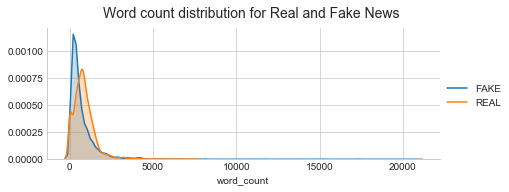

In [6]:
g = sns.FacetGrid(news, hue="label", aspect=2.5, height=2.5)
g.map(sns.kdeplot, "word_count", shade=True)
g.fig.suptitle("Word count distribution for Real and Fake News", y=1.05, size=14);
g.add_legend(title="");

The plot confirms  our summary statistics inferences. Real news articles seem to have a greater word count than fake news articles. We could do statistical tests to confirm this. Further exploration could look at the number of characters or number of sentences. We, however, are going to do this but look at readability.

### 2.2 Readability
Are fake news articles easier to read real news articles? Let's find out! We'll use a readability score to quantify this. Readability tells us the ease with which the reader can understand a text. The readability depends on the contents of the texts. It measures the complexity of the vocabulary and syntax.

We'll use the [Gunning fog index](https://en.wikipedia.org/wiki/Gunning_fog_index) to classify the readability of our news articles. This index takes into account two basic factors; 
1. The greater the average sentence length the harder the text is to read.
2. The greater the percentage of complex words, the harder the text is to read.

The formula returns a score corresponding to the grade in which someone would be able to read the text. The higher the index the harder the text is to read. I'll use the `textstat` package to get the score of every text and store it in a new column. 

In [7]:
import textstat
news['gunning_fog_score'] = news['text'].apply(lambda x: textstat.gunning_fog(x))
news[['text','label', 'gunning_fog_score']].head()

,text,label,gunning_fog_score
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,12.30
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,13.32
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,20.21
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,19.53
4,It's primary day in New York and front-runners...,REAL,16.35


Let's group by the target label and see if there is a difference between the readability score for real and fake news articles. _I don't know if textstat gives as the correct gunning fog score (the seem high), but we can use it for comparison._

In [8]:
news.groupby('label')['gunning_fog_score'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
FAKE,3164.0,20.785307,15.188323,0.0,13.3075,17.27,23.595,325.13
REAL,3171.0,23.458212,14.673496,3.6,16.1600,20.67,26.950,440.66


The summary statistics of the Gunning fog index suggest that real texts are somewhat harder to read. They also have less variation in their readability score. Which if we think about it makes some intuitive sense. If we plot the distribution of scores we also see this difference.

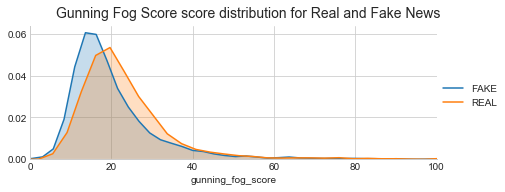

In [9]:
g = sns.FacetGrid(news, hue="label", aspect=2.5, height=2.5)
g.map(sns.kdeplot, "gunning_fog_score", shade=True)
g.fig.suptitle("Gunning Fog Score score distribution for Real and Fake News", y=1.05, size=14);
g.add_legend(title="")
plt.xlim(0,100);

## 3. Train and Validation  & First Model
Before we go and model the data we split the data into a train and validation set. We create a validation dataset to validate our classifier. We'll use 75% of the data for training the logistic and 25% for validating our model. We'll only use the text of the article, not the title, word count or readability score. Furthermore, we use stratification to ensure that we have even distribution of target label classes in the train and validation data.

In [10]:
from sklearn.model_selection import train_test_split

target = news.label.values
X_train, X_valid, y_train, y_valid = train_test_split(news, target, test_size=0.25, random_state=2, stratify=target)

f"Train shape = {X_train.shape} Test shape = {X_valid.shape}"

'Train shape = (4751, 4) Test shape = (1584, 4)'

Let's use a train a logistic regression classifier. We use stratified cross validation to validate our model.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

logreg = LogisticRegression()

kfold = StratifiedKFold(n_splits=10, random_state=2)
cv = cross_val_score(logreg, X_train[['word_count', 'gunning_fog_score']], y_train, cv=kfold)
cv.mean()

0.61734409553295

## 4. Feature Extraction and Modeling the Data
These simple statistics do not seem to really help us classify fake news. Accuracy is higher than random but I think we can do better. We need to find another way to represent text that does allow a model to make better classifications. 

### 4.1 Bag-of-words model
We will start by building a  bag-of-words model. A bag of words model is a simple way to represent text. In a bag-of-words model, we extract word tokens from the text and compute the word frequency of these tokens. Based on these frequencies and our corpus vocabulary we build word vector.  The frequency of occurrence of each word in a text is a feature we train our classifier on. 

Simply put, every row represents a text/article from the dataset, every column represents a term (word) of the dataset, and every cell contains the frequency count of that word in a particular text.

We can construct a bag of word model with  `CountVectorizer` from `sklearn`.  We fit the CountVecotrizer on the training data. After that, we transform the train and validation data. This will create a sparse matrix that we can transform into a dense matrix using the to  `toarray` function.

We also don't take stop words into account, because they often do not provide useful information.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vector = CountVectorizer(analyzer='word', stop_words='english')

count_vector_train = count_vector.fit_transform(X_train['text'])
count_vector_valid = count_vector.transform(X_valid['text'])

count_vector_train.toarray().shape

(4751, 60245)

We can see that based on training data this vector has 60245 features. Let's look at these features by using `get_feature_names` on the bag-of-words vectorizer.

In [13]:
bow_df = pd.DataFrame(data = count_vector_train.toarray(), 
            columns= count_vector.get_feature_names())
bow_df.iloc[:, 4595:4600].head()

,arguably,argue,argued,argues,arguing
0,0,0,1,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


We can see that the word "argued" occurs 1 time in the first document of our training data.

We'll use this bag-of-words model to train our logistic regression.

In [14]:
logreg = LogisticRegression()

kfold = StratifiedKFold(n_splits=10, random_state=2)
cv = cross_val_score(logreg, count_vector_train, y_train, cv=kfold)
cv.mean()

0.9155939849624062

The logistic regression algorithm performs much better on this basic bag-of-words model with a cross-validation score of 91,55%.

### 4.2 Term Frequency and Inverse Data Frequency (tf-idf)
Another way to represent text is by using term frequency-inverse data frequency (tf-idf). This way of representing text quantifies how relative importance a word is to a text and in our dataset.

$$w_{i,j} = tf_{i,j} \times \log(\frac{N}{df_i})$$

The first component (tf) calculates the word frequency $tf_{i,j}$ by counting how many times the word appears in a document $n_{i,j}$ compared to all the words in the document $\sum_kn_{i,j}$.

$$tf_{i,j} = \frac{n_{i,j}}{\sum_kn_{i,j}}$$

The second component (idf) can be calculated as the logarithm of the number of texts in the dataset, divided by the total number of texts where the specific word appears. This gives weight to every word. Rare words get a high idf score, the more common words a low score.

$$idf(w) = \log(\frac{N}{df_t})$$

tf-idf basically measures of original a word.

We can use `TfidfVectorizer` to create a tf-idf representation of our news articles by fitting and transforming the data.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(analyzer="word", stop_words='english')

tfidf_train = tfidf_vector.fit_transform(X_train['text'])
tfidf_valid = tfidf_vector.transform(X_valid['text'])

tfidf_train.toarray().shape

(4751, 60245)

Let's also extract the feature names and look at their corresponding weights.

In [16]:
tfidf_df = pd.DataFrame(data = tfidf_train.toarray(), 
            columns= tfidf_vector.get_feature_names())
tfidf_df.iloc[:, 4595:4600].head()

,arguably,argue,argued,argues,arguing
0,0.0,0.0,0.030122,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0


We can see that now there are weights assigned to the features per document.

Let's use the same logistic regression algorithm on the tf-idf representation as on the bag-of-words model. 

In [17]:
logreg = LogisticRegression()

kfold = StratifiedKFold(n_splits=10, random_state=2)
cv = cross_val_score(logreg, tfidf_train, y_train, cv=kfold)
cv.mean()

0.9103321539141973

When using tf-idf representation the logistic regression model has an accuracy of 91,03 %. This is a little less than the bag-of-words model.

### 4.3 Text processing
Both the bag-of-words and the tf-idf model have a lot of features (60,000). Let's look at ways make to turn down the number of features. 

Let's apply [lemmatization](https://en.wikipedia.org/wiki/Lemmatisatio). This process converts words into there base form. We perform lemmatization by using `nltk`'s lemmatization functionality. 

First, we define a `WordNetLemmatizer`. Then we define a lambda function that takes a string, loops over the words of the string (text), stores them in a list. Lastly, words are joined back together into a string.

In [18]:
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

X_train_lemma = X_train['text'].apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.strip().split(' ')]))
X_valid_lemma = X_valid['text'].apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.strip().split(' ')]))

Let's look at the dimensions of our bag-of-words model after applying lemmatization.

In [19]:
cv_lemma_train = count_vector.fit_transform(X_train_lemma)
cv_lemma_valid = count_vector.transform(X_train_lemma)

cv_lemma_train.toarray().shape

(4751, 58849)

We can see we lost about 2,000 features using lemmatization and removing stop words.

Let's compare some models that we fit on the bag of words representation with lemmatization applied. 

In [20]:
logreg = LogisticRegression()

kfold = StratifiedKFold(n_splits=10, random_state=2)
cv = cross_val_score(logreg, cv_lemma_train, y_train, cv=kfold)
cv.mean()

0.9160141530296328

We can see that we achieve a train accuracy score of validation score of 91.60% of the logistic regression. This model also has the lowest variance. But can we use other text representations to achieve better accuracy scores? Let's look at tf-idf with lemmatization applied.

In [21]:
tfidf_lemma_train = tfidf_vector.fit_transform(X_train_lemma)
tfidf_lemma_valid = tfidf_vector.transform(X_valid_lemma)

logreg = LogisticRegression()

kfold = StratifiedKFold(n_splits=10, random_state=2)
cv = cross_val_score(logreg, tfidf_lemma_train, y_train, cv=kfold)
cv.mean()

0.9115944272445822

The tf-idf model also improved slightly. Overall lemmatization decreased the number of features of our data without decreasing the accuracy of our classifier.

We can also combine several representations. We can create a tf-idf representation of the characters in the articles and combine them with the tf-idf word representation. Let's first create the character model. To keep the number of features smaller we set the max_features to 60000.

In [22]:
tfidf_char = TfidfVectorizer(analyzer='char', strip_accents='unicode',
                             stop_words='english', ngram_range=(2, 6),
                             max_features=60000)

tfidf_train_char = tfidf_char.fit_transform(X_train_lemma)
tfidf_valid_char = tfidf_char.transform(X_valid_lemma)

We use the `hstack()` function from SciPy to horizontally stack the sparse word and character matrices.

In [23]:
from scipy.sparse import hstack
train_features = hstack([tfidf_lemma_train, tfidf_train_char])
valid_features = hstack([tfidf_lemma_valid, tfidf_valid_char])

## 5. Final model

We train our final logistic regression classifier on the features that combine the words and character tf-idf - representations

In [24]:
logreg = LogisticRegression()

kfold = StratifiedKFold(n_splits=10, random_state=2)
cv = cross_val_score(logreg, train_features, y_train, cv=kfold)
cv.mean()

0.9318018575851392

We get an accuracy score of around __93.18%__ on the validation set!

In [25]:
logreg.fit(train_features, y_train)
logreg.score(valid_features, y_valid)

0.9343434343434344

The final testing score is 93.34% on the testing.

### 6. Conclusion
We used a logistic regression model to classify real and fake news articles. We used a bag-of-words and a tf-idf model to represent the article's texts.

This is a really simple way to classify articles, with good results. You could also use word embeddings, topic models and many more ways to represent text. 

Furthermore, you could also other classifier models, like Naive Bayes classifiers, Support Vector Machines and (Deep) Neural Nets. 

I also did not do any hyper parameter tuning to find the best model.